In [1]:
# 基础工具
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="whitegrid", palette=sns.color_palette("RdBu", 2))

# 使用的模型
from sklearn.ensemble import RandomForestClassifier

# 辅助模块
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve

### 数据预处理

In [2]:
data = pd.read_csv('train.csv')
data.dropna(axis=0,inplace=True)
data.index = range(data.shape[0])
x = data.iloc[:,1:-1]
y = np.array(data.iloc[:,-1:]).ravel()
test = pd.read_csv('test2.csv')
test.drop(['id_num','is_pass',],axis=1,inplace=True)
test = test.fillna(test.median()) #主要是为了填充age

In [3]:
# 独热编码+硬编码
newtest = test
newdata = pd.get_dummies(x,columns=['program_type','gender','program_id','is_handicapped','test_type'])
newdata.iloc[:] = OrdinalEncoder().fit_transform(newdata.iloc[:])
newtest.iloc[:] = OrdinalEncoder().fit_transform(newtest.iloc[:])

In [4]:
newdata.shape

(25427, 44)

### 模型拟合

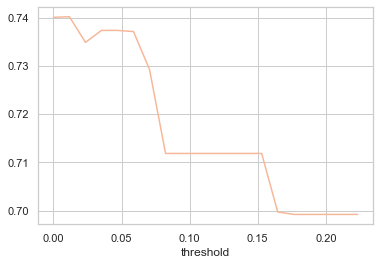

最大准确率为： 0.740157982794267 对应阈值为： 0.011762115466156643


In [5]:
## 运用学习曲线寻找最优的阈值
rfc = RandomForestClassifier(random_state=0)
threshold = np.linspace(0,(rfc.fit(newdata,y).feature_importances_).max()-0.01,20)
score = []
for i in threshold:
    X_embedded = SelectFromModel(rfc,threshold=i).fit_transform(newdata,y)
    score.append(cross_val_score(rfc,X_embedded,y,cv=5).mean())
fig, ax = plt.subplots()
ax.plot(threshold,score)
ax.set_xlabel('threshold')
plt.show()
print('最大准确率为：',max(score),'对应阈值为：',threshold[score.index(max(score))])

In [6]:
# 嵌入法优化模型
sfm = SelectFromModel(rfc, threshold=threshold[score.index(max(score))]).fit(newdata,y)
X_embedded = sfm.transform(newdata)

In [7]:
X_embedded.shape

(25427, 13)

In [8]:
# 输出嵌入法优化后的模型准确率
score = cross_val_score(rfc,X_embedded,y,cv=5).mean()
score

0.740157982794267